Each task that is proposed to be completed as part of the homework has a declared "price" in points. The maximum possible amount is 10 points, and together with the bonus assignment - 12 points. It is not necessary to complete all the tasks, only a part can be done. Most of the points expect you to write working Python code; sometimes you will need to write comments - for example, to compare several approaches to solve the same problem. Also you can add more cells for your convenience if you need.

This homework focuses on clustering. We will work with images of handwritten digits, learn how to cluster them using two different methods (hierarchical clustering and the 𝐾-means algorithm), evaluate the quality of the partition and choose the optimal number of clusters, as well as visualize intermediate results.

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker 
import numpy as np
from numpy.random import RandomState

from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.exceptions import NotFittedError
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, v_measure_score
from sklearn.decomposition import TruncatedSVD, PCA

## 1. Loading data
The data we will be working with is available in the scikit-learn library (`sklearn` module) in the `datasets` submodule via the `load_digits` function. The data contains 1,797 observations, each of which is 8×8 pixel image of a handwritten digit from 0 to 9. This is about the same amount of each digit (about 180).

For convenience, every image expands to a 64 (8×8) row, so entire numpy array is 1797×64. The color intensity in each pixel is encoded with an integer from 0 to 16.

In addition to images, their labels are also known. In this task, we will assume that the labels (as well as their amount) are unknown and try to group the data in such a way that the resulting clusters 'better match' the original ones. Possible options for determining the 'better match' are presented later.

**(0.25 points)** Load the images into `X` variable, and their labels into `y` variable.

In [1]:
from sklearn.datasets import load_digits

X, y = load_digits(return_X_y=True)

In [2]:
assert X.shape == (1797, 64)
assert y.shape == (1797,)

**(0.5 points)** Visualize the first 10 images.

- Arrange images on a grid rather than in a row. You may need the `subplot` and `imshow` functions from the `pyplot` module in the `matplotlib` library.
- You will also need to reshape the images to 8×8.
- Remove ticks and labels from both axes. The `xticks` and `yticks` functions or the `tick_params` function from `pyplot` can help you with this.
- Make the output good sized with the `figure` function from `pyplot`.

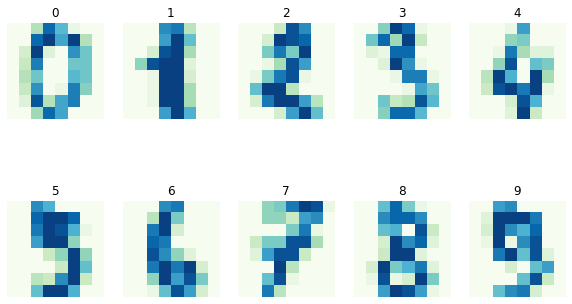

In [3]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,6))

for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.GnBu)
    ax.set_title(label)

## 2. Clustering and quality evaluation

**(2 points)** Implement the the KMeans algorithm. Use objective function $L = \sum_{i=1}^{n}|x_{i}-Z_{A(x_{i})}|^{2}$, where $Z_{A(x_{i})}$ is the center of the cluster corresponding to $x_{i}$ object.

In [51]:
class CustomKMeans:
    def __init__(self, n_clusters=2, max_iter=30, n_init=10, random_state=42):
        '''K-Means clustering.
        
        Args:
            n_clusters: int, default=2
                The number of clusters to be formed is also 
                the number of centroids to generate. 
            max_iter: int, default=300
                Maximum number of iterations of the k-means algorithm for a
                single run.
            n_init: int, default=10
                Number of time the k-means algorithm will be run with different
                centroid seeds. The final results will be the best output of
                n_init consecutive runs in terms of objective function.
            random_state: int, default=42
                Random state.
        '''
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.random_state = RandomState(seed=random_state)
        
    def calculate_distances_to_centroids(self, X, cluster_centers):
        """
        Returns (n, c) matrix where the element at position (i, j) 
        is the distance from i-th object to j-th centroid."""
        # <your code>
        distances = np.zeros(shape=(X.shape[0], cluster_centers.shape[0]))

        for i in range(X.shape[0]):
            for j in range(cluster_centers.shape[0]):
                distances[i][j] = np.linalg.norm(X[i] - cluster_centers[j], 2)
        return distances
    
    def update_centroids(self, X, nearest_clusters):
        """
        Returns numpy array of shape (n_clusters, n_features) - 
        new clusters that are found by averaging objects belonging 
        to the corresponding cluster."""
        # <your code>
        clusters = set(nearest_clusters)
        new_centroids = []
        
        for cl in clusters:
            new_centroid = X[nearest_clusters == cl].mean(axis=0)
            new_centroids.append(new_centroid)
        return np.array(new_centroids)
        
    def fit(self, X):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        """
        assert X.shape[0] >= self.n_clusters
        # <your code>
        for i in range(self.n_init):
            # выберем случайные точки из X в качестве центроидов
            rows_idx = self.random_state.choice(X.shape[0], self.n_clusters)
            centroids = X[rows_idx]
            nearest_clusters = np.zeros(X.shape[0])
            
            # найдем оптимальные центроиды
            for j in range(self.max_iter):
                distances = self.calculate_distances_to_centroids(X, centroids)
                new_nearest_clusters = distances.argmin(axis=1)
                if (new_nearest_clusters == nearest_clusters).all():
                    break
                nearest_clusters = new_nearest_clusters
                centroids = self.update_centroids(X, nearest_clusters)
            
            # посчитаем objective для найденных центроидов
            objective = (distances.min(axis=1)**2).sum() # В памяти сохранились distances с последней итерации (для лучших центроидов)
            
            if i == 0 or objective < self.best_objective:
                self.best_objective = objective
                self.cluster_centers_ = centroids
                self.labels_ = nearest_clusters
                    
        return self
            
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted cluster labels.
        """
        if hasattr(self, 'cluster_centers_'):
            # <your code>
            distances = self.calculate_distances_to_centroids(X, self.cluster_centers_)
            return distances.argmin(axis=1)
        else: 
            raise NotFittedError("CustomKMeans instance is not fitted yet")

**(1 points)** Get the `X` array partition into 10 clusters. Visualize the centers of clusters.
- We will assume that the center of the cluster is average value of all observations belonging to the cluster.
- The cluster centers should have the same shape as our observations (64). So you have to average the points across the rows.

In [113]:
%%time
kmeans = CustomKMeans(n_clusters=10).fit(X)

CPU times: user 17 s, sys: 55.9 ms, total: 17.1 s
Wall time: 17.1 s


In [114]:
custom_kmeans_labels = kmeans.labels_
assert custom_kmeans_labels.shape == (1797,)

In [147]:
def plot_number_clusters(X, title):
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,6))

    for ax, image, label in zip(axes.flatten(), X, range(10)):
        ax.set_axis_off()
        ax.imshow(image.reshape((8, 8)), cmap=plt.cm.GnBu)
        ax.set_title(f'cluster {label}')
    fig.suptitle(title)

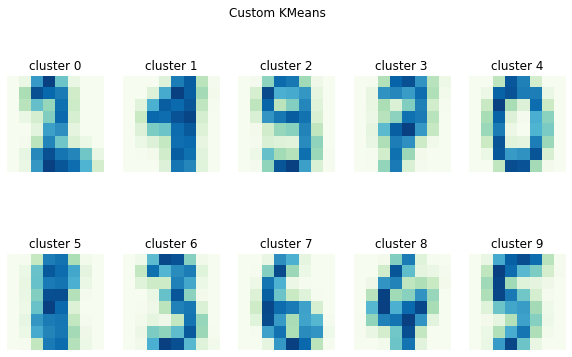

In [148]:
plot_number_clusters(kmeans.cluster_centers_, 'Custom KMeans')

**(0.5 points)** Experiment with `max_iter` and `n_init` parameters. Look at the range of values of the objective function, it's best values, at what parameters and how often they are achieved.

In [95]:
max_iters = [10, 20, 50, 100]
n_inits = [1, 2, 5, 10, 20]

max_iter = 10, objectives=[1249307.0166282258, 1238689.6615855775, 1173130.250943512, 1166168.7958291704, 1166168.7958291704], min_obj=1166168.7958291704
max_iter = 20, objectives=[1239803.108706636, 1237969.7032719788, 1172321.7387749928, 1165196.6030573712, 1165196.6030573712], min_obj=1165196.6030573712
max_iter = 50, objectives=[1238746.580160237, 1237969.7032719788, 1172321.7387749928, 1165188.3215690907, 1165188.3215690907], min_obj=1165188.3215690907
max_iter = 100, objectives=[1238746.580160237, 1237969.7032719788, 1172321.7387749928, 1165188.3215690907, 1165188.3215690907], min_obj=1165188.3215690907


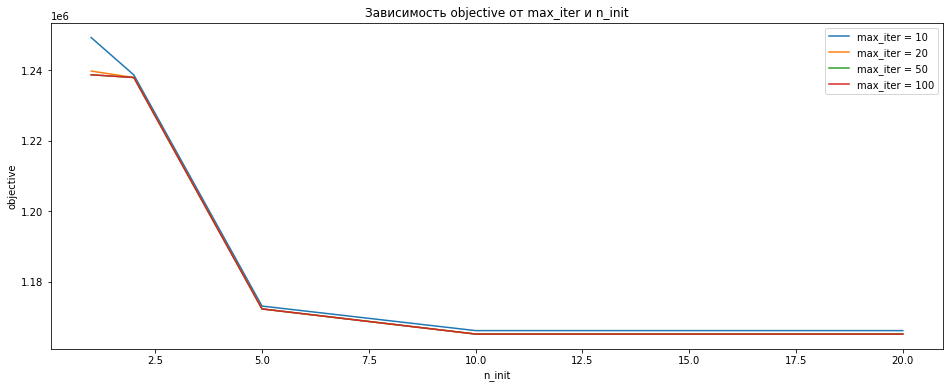

In [101]:
fig, ax = plt.subplots(figsize=(16,6))
for max_iter in max_iters:
    objectives = []
    for n_init in n_inits:
        kmeans = CustomKMeans(n_clusters=10, max_iter=max_iter, n_init=n_init).fit(X)
        objectives.append(kmeans.best_objective)
    ax.plot(n_inits, objectives, label=f'max_iter = {max_iter}')
    print(f'max_iter = {max_iter}, objectives={objectives}, min_obj={min(objectives)}')
ax.set_title('Зависимость objective от max_iter и n_init')
ax.set_xlabel('n_init')
ax.set_ylabel('objective')
ax.legend()

In [102]:
CustomKMeans(n_clusters=10, max_iter=300, n_init=30).fit(X).best_objective

1165188.3215690907

Для всех max_iter в точке при n_init=5 наблюдается излом, после которого objective меняется незначительно. При этом, при повышении max_iter objective немного снижается, однако разница после 20 не особо заметна. Минимальным значением objective является 1165188.3215690907, при этом оно достигается при max_iter>=50 и n_init>=10

Now we will use two popular algorithms: hierarchical clustering and $K$-means clustering. These and other algorithms are available in the `scikit-learn` module in the `cluster` submodule. Hierarchical clustering is called `AgglomerativeClustering`, and the $K$-means method is called `KMeans`.

**(0.5 points)** Use each of the two methods: hierarchical clustering and KMeans. Get the `X` array partition into 10 clusters.

- Note that `AgglomerativeClustering` does not have a `predict` method, so you can either use the `fit_predict` method or use the `fit` method and then look at the `labels_` attribute of the class instance.
- Kmeans performs multiple runs (default 10) with random centers and then returns the best partition in terms of average distance within the clusters. You can increase the number of runs to improve the quality of predictions in the `i_init` parameter.

In [201]:
kmeans = KMeans(n_clusters=10, n_init=20).fit(X)
hierarchical = AgglomerativeClustering(n_clusters=10).fit(X)

In [202]:
hierarchical_labels = hierarchical.labels_
kmeans_labels = kmeans.labels_

In [203]:
assert hierarchical_labels.shape == (1797,)
assert kmeans_labels.shape == (1797,)

**(0.5 points)** Visualize the centers of clusters obtained by both methods.

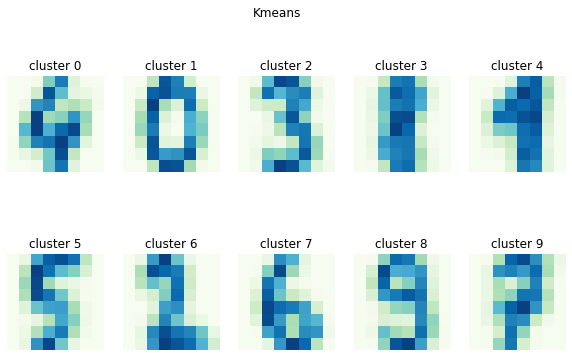

In [204]:
plot_number_clusters(kmeans.cluster_centers_, 'Kmeans')

In [205]:
clusters = set(hierarchical_labels)
new_centroids = []

for cl in clusters:
    new_centroid = X[hierarchical_labels == cl].mean(axis=0)
    new_centroids.append(new_centroid)
hierarchical_cluster_centers = np.array(new_centroids)

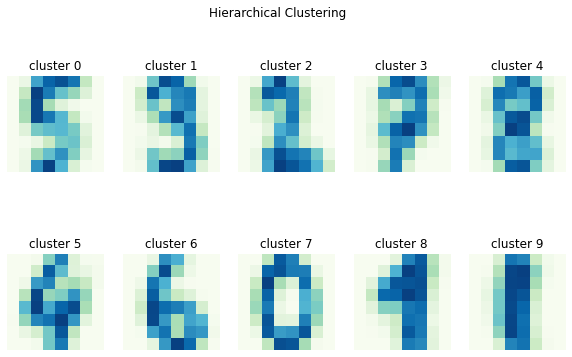

In [206]:
plot_number_clusters(hierarchical_cluster_centers, 'Hierarchical Clustering')

In a situation where the true number of classes is unknown, we can select it by maximazing some metric.

When we can set some distance function between our observations, we can consider the `silhouette` distance as a function of measuring the quality of the clustering. Let's show how it is calculated:

Let $X$ – set of observations, $M \subset X$ – one of the clusters obtained as a result of clustering process, $\rho$ – some metric on $X$. Let's choose one observation $x \in M$. Denote $a(x)$ as the average distance from $x$ to  $x'$ points from the same cluster:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Denote $b(x)$ as minimun of average distances from $x$ to $x''$ from some other cluster $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

The silhouette is difference between a(x) and b(x), normalized to $[-1, \, 1]$ and averaged over all observations:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

The implementation of this metric in the `scikit-learn` is the `silhouette_score` function from the `metrics` submidule.

**(0.75 point)** For each $K$ between 2 and 20 inclusive, partition of the array $X$ into $K$ clusters using both methods. Calculate the silhouette score and visualize it for both methods on the same plot ($K$ on the $x$ axis and silhouette score on the $y$ axis). Sign the axes and make a legend.

In [216]:
K = list(range(2,21))
silhouettes_kmeans = []
silhouettes_hierarchical = []

for k in K:
    kmeans = KMeans(n_clusters=k).fit(X)
    silhouettes_kmeans.append(silhouette_score(X, kmeans.labels_))
    
    hierarchical = AgglomerativeClustering(n_clusters=k).fit(X)
    silhouettes_hierarchical.append(silhouette_score(X,  hierarchical.labels_))

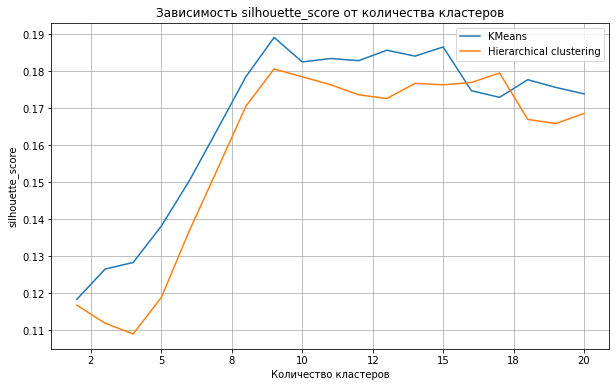

In [217]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(K, silhouettes_kmeans, label='KMeans')
ax.plot(K, silhouettes_hierarchical, label='Hierarchical clustering')
ax.set_title('Зависимость silhouette_score от количества кластеров')
ax.set_xlabel('Количество кластеров')
ax.set_ylabel('silhouette_score')
ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:.0f}"))
ax.grid()
ax.legend();

When we know the true clustering labels, the clustering result can be compared to them using measures such as `homogeneity`, `completeness` and their harmonic mean - $V$-score. The definitions of these quantities are rather bulky and are based on the [entropy of the probability distribution](https://ru.wikipedia.org/wiki/Информационная_энтропия). Details are given in [this article](http://aclweb.org/anthology/D/D07/D07-1043.pdf). In practice, it's enough to know that `homogeneity`, `completeness` and $V$-score are in the range from 0 and 1, and the more, the better.

Since we know what digit each image is (`y` array), we can compare the clustering results to it using the measures listed above.

**(0.5 points)** Repeat the previous task using $V$-measure instead of silhouette.

In [218]:
K = list(range(2,21))
vscores_kmeans = []
vscores_hierarchical = []

for k in K:
    kmeans = KMeans(n_clusters=k).fit(X)
    vscores_kmeans.append(v_measure_score(y, kmeans.labels_))
    
    hierarchical = AgglomerativeClustering(n_clusters=k).fit(X)
    vscores_hierarchical.append(v_measure_score(y,  hierarchical.labels_))

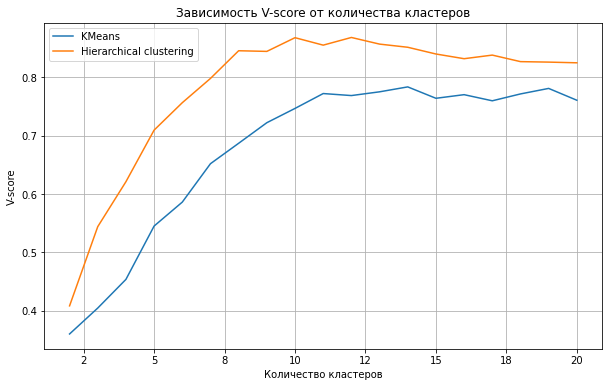

In [219]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(K, vscores_kmeans, label='KMeans')
ax.plot(K, vscores_hierarchical, label='Hierarchical clustering')
ax.set_title('Зависимость V-score от количества кластеров')
ax.set_xlabel('Количество кластеров')
ax.set_ylabel('V-score')
ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:.0f}"))
ax.grid()
ax.legend();

## 3. Feature space dimensionality reduction

In some cases, especially when there are a large number of features, when not all of them are informative, and some of them are correlated, it can be useful to reduce the dimension of the feature space. This mean that instead of $d$ original features, we will go to $d'\ll d$ new ones. And if earlier our data were presented in the form of an $n×d$ matrix, then it will presented as a $n×d'$.

There are two popular dimensionality reduction approaches:
- select new features from existing features;
- extract the new features by transforming old ones, for example, by making $d'$ different linear combinations of columns of an $n×d$ matrix.

One widely used dimensionality reduction technique is the Singular Value Decomposition (SVD). This method allows you to construct any number $d'\leq d$ of new features in such a way that they are the most informative (in some sense).

The `scikit-learn` module has several implementations of singular value decomposition. We will use the `TruncatedSVD` class from the `decomposition` submodule.

**Note:** The singular value decomposition of the matrix $M$ is usually written as $M=U \Sigma V^{*}$. `TruncatedSVD`, in turn, returns only the $d'$ first columns of the matrix $U$.

**(0.75 point)** Perform a singular value decomposition of the $X$ matrix, leaving 2, 5, 10, 20 features. In each case, perform hierarchical clustering and $K$-Means clustering (take the number of clusters equal to 10). Calculate the silhouette and $V$-score and compare them to corresponding values obtained from the original data.

**Note**: It is not valid to compare the silhouette calculated with different metrics. Even if we use the same metric function when calculating the distance between points in the data, after applying dimensionality reduction or other data transformations, we will (not always) get different silhouette scores. Therefore, after training the clustering algorithm, to compare the result of clustering, you need to calculate the silhouette on the original data.

In [244]:
D = [2, 5, 10, 20]

silhouettes_kmeans_svd = []
vscores_kmeans_svd = []

vscores_hierarchical_svd = []
silhouettes_hierarchical_svd = []

for d in D:
    X_reduced = TruncatedSVD(n_components=d).fit_transform(X)
    kmeans = KMeans(n_clusters=10).fit(X_reduced)
    silhouettes_kmeans_svd.append(silhouette_score(X, kmeans.labels_))
    vscores_kmeans_svd.append(v_measure_score(y, kmeans.labels_))
    
    hierarchical = AgglomerativeClustering(n_clusters=10).fit(X_reduced)
    silhouettes_hierarchical_svd.append(silhouette_score(X, hierarchical.labels_))
    vscores_hierarchical_svd.append(v_measure_score(y,  hierarchical.labels_))

In [269]:
kmeans = KMeans(n_clusters=10).fit(X)
hierarchical = AgglomerativeClustering(n_clusters=10).fit(X)

In [270]:
print(f'Silhouette. KMeans: {silhouette_score(X, kmeans.labels_)} , Hierarchical: {silhouette_score(X, hierarchical.labels_)}')
print(f'V-score. KMeans: {v_measure_score(y, kmeans.labels_)} , Hierarchical: {v_measure_score(y, hierarchical.labels_)}')

Silhouette. KMeans: 0.18244673954521853 , Hierarchical: 0.17849659940596496
V-score. KMeans: 0.7420358247453557 , Hierarchical: 0.8681701126909083


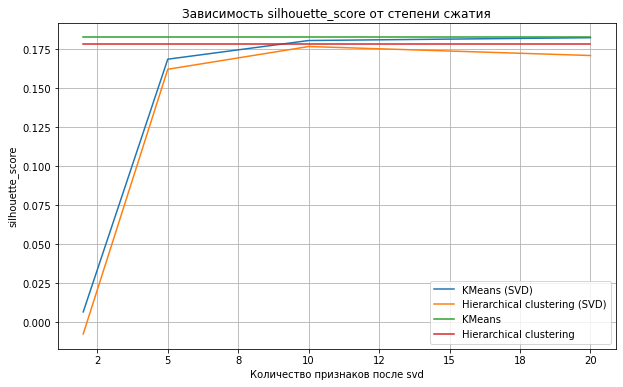

In [246]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(D, silhouettes_kmeans_svd, label='KMeans (SVD)')
ax.plot(D, silhouettes_hierarchical_svd, label='Hierarchical clustering (SVD)')
ax.plot(D, [silhouette_score(X, kmeans.labels_)]*4, label='KMeans')
ax.plot(D, [silhouette_score(X, hierarchical.labels_)]*4, label='Hierarchical clustering')
ax.set_title('Зависимость silhouette_score от степени сжатия')
ax.set_xlabel('Количество признаков после svd')
ax.set_ylabel('silhouette_score')
ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:.0f}"))
ax.grid()
ax.legend();

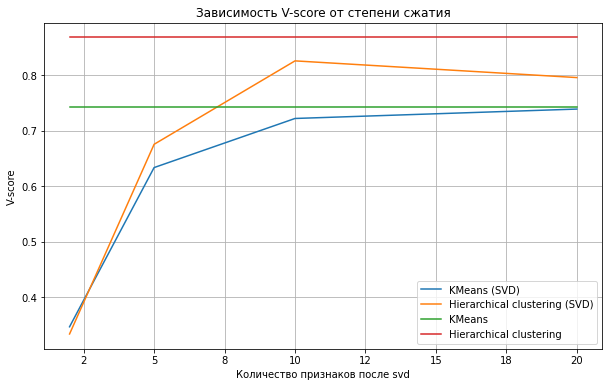

In [247]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(D, vscores_kmeans_svd, label='KMeans (SVD)')
ax.plot(D, vscores_hierarchical_svd, label='Hierarchical clustering (SVD)')
ax.plot(D, [v_measure_score(y, kmeans.labels_)]*4, label='KMeans')
ax.plot(D, [v_measure_score(y, hierarchical.labels_)]*4, label='Hierarchical clustering')
ax.set_title('Зависимость V-score от степени сжатия')
ax.set_xlabel('Количество признаков после svd')
ax.set_ylabel('V-score')
ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:.0f}"))
ax.grid()
ax.legend();

При сокращении размерности теряется часть информации, поэтому качество кластеризации по обеим метрикам после SVD хуже. Однако если брать не слишком маленькое число новых признаков, то это падение качества не очень большое. Например после 10 силуэт и v-score не сильно отличаются у моделей натренированных на полных данных и на сжатых

Another popular dimensionality reduction approach that is useful for working with images is t-distributed stochastic neighbor embeddings, abbreviated `tSNE`. Unlike singular value decomposition, this it is non-linear transformation. It's main idea is to map points from a space of dimension `d` to another space of dimension 2 or 3 in such a way that the distances between points are mostly preserved. Mathematical details can be found, for example, [here](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).

The implementation of `tSNE` in the `scikit-learn` library is the `TSNE` class in the `manifold` submodule.

**Note:** In recent years [UMAP](https://github.com/lmcinnes/umap) is often used istead of `tSNE`. It is a faster algorithm with similar properties. We don't ask you to use `UMAP` because it requires you to install another dependency, the `umap-learn` library. Those who wish can perform the following task using `UMAP`.

**(0.5 points)** Perform a tSNE-transform of the `X` matrix, leaving 2 features. Visualize the obtained data in the form of a scatter plot form: the first feature on the horizontal axis, and the second one the vertical axis. Color the points according to the digits they belong to.

- The `c` parameter in the plt.scatter function is responsible for the color of the points. Pass the true labels to it.

In [250]:
X_tsne = TSNE(n_components=2).fit_transform(X)
X_tsne.shape

(1797, 2)

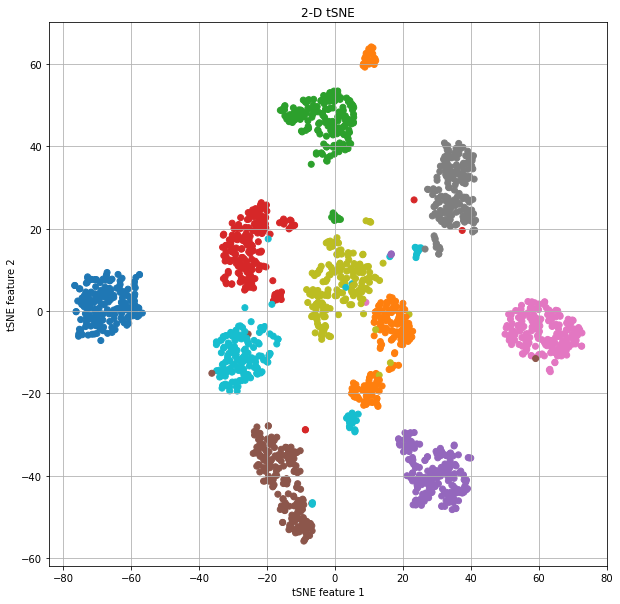

In [260]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(X_tsne[:,0], X_tsne[:,1], c=y, cmap=plt.cm.tab10)
ax.set_title('2-D tSNE')
ax.set_xlabel('tSNE feature 1')
ax.set_ylabel('tSNE feature 2')
ax.grid();

**(0.5 points)** From the data transformed using the tSNE, perform hierarchical clustering and $K$-means clustering (take the number of clusters equal to 10). Calculate the silhouette and the $V$-score and compare them to corresponding values obtained from the original data.

In [273]:
kmeans_tsne = KMeans(n_clusters=10).fit(X_tsne)
hierarchical_tsne = AgglomerativeClustering(n_clusters=10).fit(X_tsne)

In [276]:
print(f'Silhouette (original). KMeans: {silhouette_score(X, kmeans.labels_)} , Hierarchical: {silhouette_score(X, hierarchical.labels_)}')
print(f'Silhouette (tSNE). KMeans: {silhouette_score(X, kmeans_tsne.labels_)} , Hierarchical: {silhouette_score(X, hierarchical_tsne.labels_)}')
print()

print(f'V-score (original). KMeans: {v_measure_score(y, kmeans.labels_)} , Hierarchical: {v_measure_score(y, hierarchical.labels_)}')
print(f'V-score (tSNE). KMeans: {v_measure_score(y, kmeans_tsne.labels_)} , Hierarchical: {v_measure_score(y, hierarchical_tsne.labels_)}')

Silhouette (original). KMeans: 0.18244673954521853 , Hierarchical: 0.17849659940596496
Silhouette (tSNE). KMeans: 0.16420876731285508 , Hierarchical: 0.16484163874905447

V-score (original). KMeans: 0.7420358247453557 , Hierarchical: 0.8681701126909083
V-score (tSNE). KMeans: 0.9180346401103182 , Hierarchical: 0.9095882232906942


Силуэт после применения tSNE немного снизился в обеих моделях. При этом V-score стал выше как в KMeans, так и в hierarchical clustering

**(0.25 points)** Choose the best partition (in terms of silhouette or $V$-score) and visualize the centers of clusters with images. Did you managed to make each digit correspond to one center of the cluster?

In [281]:
print(max(silhouettes_kmeans_svd))
print(max(silhouettes_hierarchical_svd))

print(max(vscores_kmeans_svd))
print(max(vscores_hierarchical_svd))

0.18225347289773663
0.1765881132796084
0.7391035100863055
0.8259753348813222


Наилучший показатель наблюдается у KMeans, обученной на сжатых при помощи tSNE данных. При этом V-score у этой модели даже выше, чем у модели, обученной на оригинальных данных

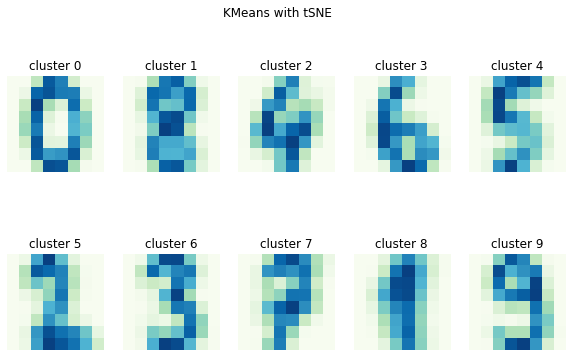

In [285]:
clusters = set(kmeans_tsne.labels_)
kmeans_tsne_centroids = []

for cl in clusters:
    centroid = X[kmeans_tsne.labels_ == cl].mean(axis=0)
    kmeans_tsne_centroids.append(centroid)
plot_number_clusters(np.array(kmeans_tsne_centroids), 'KMeans with tSNE')

На мой взгляд, цифры распознались достаточно четко. Особенно 3 и 8, которые на предыдущих итерациях были плохо различимы

## 4. Results and bonus part

Write in free form what conclusions you made after completing this assignment. Answer the following questions:

**(0.5 points)** Which algorithm gives more meaningful results - hierarchical clustering or $K$- means clustering. Does it depend on the algorithm settings or on the quality evaluation method?

В задаче кластеризации рукописных цифр, которую мы решали, на мой взгляд, лучше себя показал KMeans, так как визуально центры кластеров у него более четкие, чем у hierarchical clustering. KMeans плохо распознал 8, но при этом ее можно узнать. Hierarchical clustering же плохо распознал 9, при этом понять, что это 9 почти невозможно. Он также хуже распознал 3. Что касается метрик качества, то тут неоднозначная ситуция - у KMeans выше силуэт, но ниже V-score.
<br>
<br>
Основное отличие алгоритмов в том, что KMeans идет сверху-вниз, то есть сначала все данные разбивает на k кластеров, а затем просто меняет состав этих кластеров, а hierarchical clustering, наоборот, считает снизу-вверх, то есть изначально каждое наблюдение формирует собственный кластер, затем он объединяет кластеры до достижения k (если задано). Проблема в том, что KMeans сильно зависит от начальных центров кластеров и чтобы найти оптимум нужно несколько раз прогонять алгоритм (n_init) и если n_init маленький, то есть риск найти неправильные кластера, а высокий n_init линейно увеличивает нагрузку. Hierarchical clustering сразу идет по оптимальному пути и за один проход находит нужные кластеры. При этом в задачах, где количество кластеров заранее неизвестно Hierarchical clustering может помочь найти это k, так как он строит дендограмму из которой потом можно определить приемлемый порог и в зависимости от него определить количество кластеров в данных.
<br>
<br>
Таким образом, в общем случае hierarchical clustering выглядит более предпочтительным алгоритмом, однако в случае, когда известно количество кластеров и их метки, как в нашей задаче, KMeans может показывать результаты лучше

**(0.5 points)** Imagine the situation where after hierarchical clustering, you need to cluster new data in the same way without retraining the model. Suggest a method how you will do it and how you will measure the quality of clustering of new data.

После обучения модели можно найти центры полученных кластеров. Для новых данных нужно посчитать расстояния до этих центров и для каждого наблюдения выбрать тот центр, который находится ближе всего. Метку для этого наблюдения поставить такую же, как и у центра, к которому мы его отнесли. Качество предсказаний для новых данных можно измерить при помощи силуэта. Если силуэт, полученный только из новых данных, примерно равен силуэту, полученному на тренировочных данных, то качество модели хорошее. 

**(0.5 points)** Does dimensionality reduction improve clustering results?

Снижение размерности должно отбрасывать часть информации и оставлять только наиболее важную. С одной стороны, мне казалось, что потеря информации в любом случае ухудшит качество модели. Однако в последнем задании у меня получилось улучшить кластеризацию при помощи tSNE. Это улучшение выражается как в визуальной оценке - цифры стали более четкими, так и в показателе V-score - он вырос после трансформации признаков. Также нужно отметить, что сокращение размерности сильно сокращает время, необходимое на обучение моделей

**(0.5 points)** How to evaluate the quality of dimensional reduction? Suggest at least 2 options.

1) можно сравнить показатели качества модели до и после применения снижения размерности
2) для алгоритмов, стремящихся сохранить попарные расстояния можно рассчитать метрику: (((di_old - di_new)**2).sum())**0.5 - где di - попарные расстояния. Эта метрика будет показывать насколько суммарно изменились расстояния между парами и чем она ближе к нулю, тем лучше - тем больше информации о принадлежности к кластерам сохранилось
3) можно визуально оценить, насколько сохранилось разбиение по кластерам. Это применимо только, если финальная размерность 2 или 3
4) оценить экономию ресурсов, вызванных сокращением вычислений. Например, время и объем потребленной памяти

**(Bonus 2 points)** Load the [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist) dataset. You can also do it with `scikit-learn` as explained [here](https://stackoverflow.com/a/60450028). Explore the data and try to cluster it using different approaches. Compare results of these approaches using the silhouette and the $V$-score.

In [3]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.to_numpy()

In [4]:
X.shape, y.shape

((70000, 784), (70000,))

In [5]:
X.shape[1]**0.5

28.0

In [6]:
set(y)

{'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'}

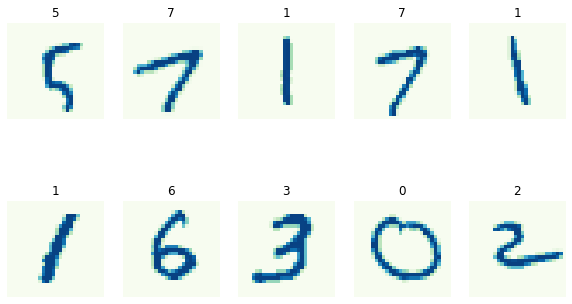

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,6))

for ax, image, label in zip(axes.flatten(), X[100:111], y[100:111]):
    ax.set_axis_off()
    ax.imshow(image.reshape((28, 28)), cmap=plt.cm.GnBu)
    ax.set_title(label)

Из-за более высокого разрешения, чем в первой задаче, цифры выглядят достаточно четкими

In [8]:
def get_metrics(X, y_true, y_pred, model_name):
    silhouette = round(silhouette_score(X, y_pred), 4)
    vscore = round(v_measure_score(y_true, y_pred), 4)
    print(f'{model_name}. Silhouette score: {silhouette}, V-score: {vscore}')
    return


def get_clusters_centers(X, y):
    clusters = list(set(y))  
    centroids = []
    for cl in clusters:
        centroid = X[y == cl].mean(axis=0)
        centroids.append(centroid)
    return np.array(centroids)


def plot_centers(cluster_centers, labels, model_name):

    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,6))
    
    for ax, image, label in zip(axes.flatten(), cluster_centers, labels):
        ax.set_axis_off()
        ax.imshow(image.reshape(28, 28), cmap=plt.cm.GnBu)
        ax.set_title(label)
    fig.suptitle(model_name)

    return

## KMeans

In [9]:
%%time
kmeans = KMeans(n_clusters=10).fit(X)

CPU times: user 5min 2s, sys: 9.01 s, total: 5min 11s
Wall time: 25.4 s


KMeans. Silhouette score: 0.056, V-score: 0.4853


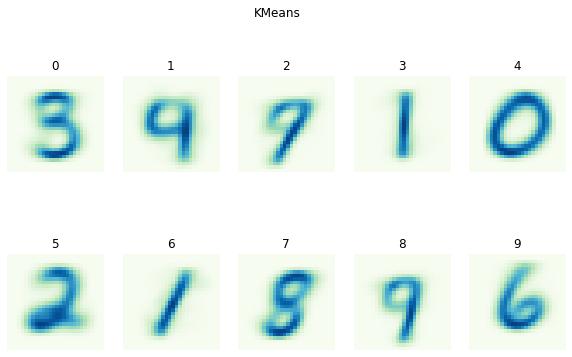

In [10]:
get_metrics(X, y_true=y, y_pred=kmeans.labels_, model_name='KMeans')
plot_centers(cluster_centers=kmeans.cluster_centers_, labels=list(set(kmeans.labels_)), model_name='KMeans')

Результаты кластеризации получились некачественные. Во-первых, визуально видно, что некоторые центры похожи и изображают одну и ту же цифру (1, 6, 9). Во-вторых, достаточно низкие Silhouette score и V-score. В-третьих, из-за большой размерности алгоритм достаточно долго обучается.

Чтобы ускорить время обучения, выберем сэмпл из данных и проверим, что эта выборка хорошо отражает генеральную совокупность

In [11]:
random_state = RandomState(seed=42)

In [12]:
rand_idx = random_state.choice(range(70000), size=5000, replace=False)
X_sample , y_sample = X[rand_idx], y[rand_idx]
X_sample.shape , y_sample.shape

((5000, 784), (5000,))

In [14]:
y_sample.value_counts()

3    556
1    551
9    517
7    515
0    490
6    490
8    489
2    483
5    476
4    433
Name: class, dtype: int64

KMeans (sample). Silhouette score: 0.0604, V-score: 0.4902
CPU times: user 24.4 s, sys: 1.78 s, total: 26.2 s
Wall time: 2.29 s


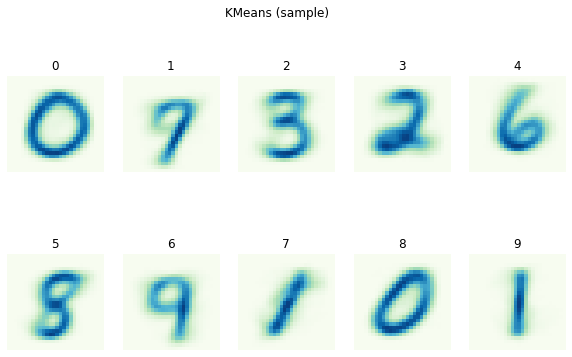

In [19]:
%%time
kmeans_sample = KMeans(n_clusters=10).fit(X_sample)
get_metrics(X_sample, y_true=y_sample, y_pred=kmeans_sample.labels_, model_name='KMeans (sample)')
plot_centers(cluster_centers=kmeans_sample.cluster_centers_, labels=list(set(kmeans_sample.labels_)), model_name='KMeans (sample)')

На этой выборке алгоритм считает быстрее, при этом качество примерно такое же. Равномерность классов не нарушена. Будем дальше работать с ним

Попробуем сократить размерность при помощи PCA

### PCA

In [20]:
%%time
pca_2 = PCA(n_components=2).fit(X_sample)
X_pca_2 = pca_2.transform(X_sample)
X_pca_2.shape

CPU times: user 687 ms, sys: 37.8 ms, total: 725 ms
Wall time: 115 ms


(5000, 2)

KMeans PCA 2. Silhouette score: 0.0179, V-score: 0.3628


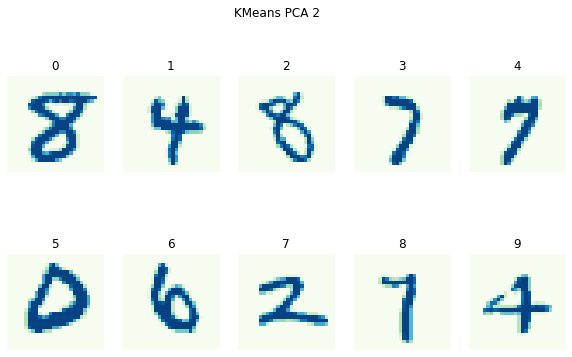

In [30]:
kmeans_pca_2 = KMeans(n_clusters=10).fit(X_pca_2)
get_metrics(X=X_sample, y_true=y_sample, y_pred=kmeans_pca_2.labels_, model_name='KMeans PCA 2')
plot_centers(X_sample, list(set(kmeans_pca_2.labels_)), 'KMeans PCA 2')

Качество кластеризации упало, однако визуально все цифры стали более четкими. Попробуем увеличить размерность

In [22]:
%%time
pca_10 = PCA(n_components=10).fit(X_sample)
X_pca_10 = pca_10.transform(X_sample)
X_pca_10.shape

CPU times: user 710 ms, sys: 36.1 ms, total: 746 ms
Wall time: 118 ms


(5000, 10)

In [23]:
%%time
kmeans_pca_10 = KMeans(n_clusters=10).fit(X_pca_10)

CPU times: user 3.93 s, sys: 921 ms, total: 4.85 s
Wall time: 454 ms


KMeans PCA 10. Silhouette score: 0.0607, V-score: 0.4724
CPU times: user 3.64 s, sys: 323 ms, total: 3.96 s
Wall time: 511 ms


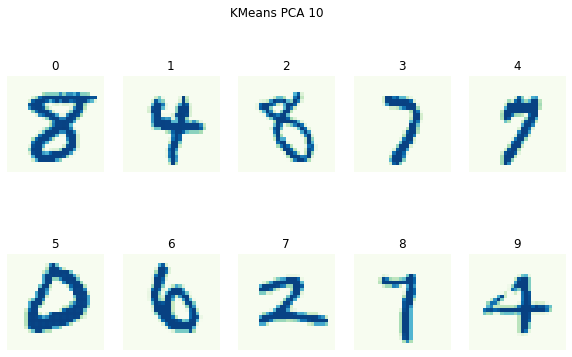

In [24]:
%%time
get_metrics(X=X_sample, y_true=y_sample, y_pred=kmeans_pca_10.labels_, model_name='KMeans PCA 10')
plot_centers(X_sample, list(set(kmeans_pca_10.labels_)), 'KMeans PCA 10')

Качество кластеризации вернулось к значениям, близким до сокращения размерности. Попробуем увеличить n_init и max_iter

KMeans PCA 10. Silhouette score: 0.0608, V-score: 0.4726


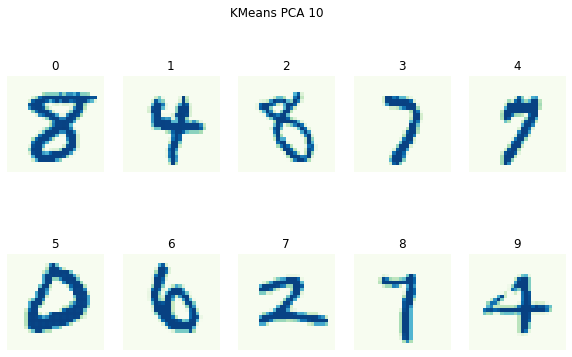

In [32]:
kmeans_pca_10 = KMeans(n_clusters=10, n_init=30, max_iter=1000).fit(X_pca_10)
get_metrics(X=X_sample, y_true=y_sample, y_pred=kmeans_pca_10.labels_, model_name='KMeans PCA 10')
plot_centers(X_sample, list(set(kmeans_pca_10.labels_)), 'KMeans PCA 10')

Качество почти не поменялось

Попробуем увеличить размерность до 100

In [33]:
%%time
pca_100 = PCA(n_components=100).fit(X_sample)
X_pca_100 = pca_100.transform(X_sample)
X_pca_100.shape

CPU times: user 1.11 s, sys: 48.2 ms, total: 1.16 s
Wall time: 172 ms


(5000, 100)

In [34]:
%%time
kmeans_pca_100 = KMeans(n_clusters=10).fit(X_pca_100)

CPU times: user 5.55 s, sys: 883 ms, total: 6.43 s
Wall time: 560 ms


KMeans PCA 100. Silhouette score: 0.0593, V-score: 0.4915
CPU times: user 2.53 s, sys: 198 ms, total: 2.73 s
Wall time: 541 ms


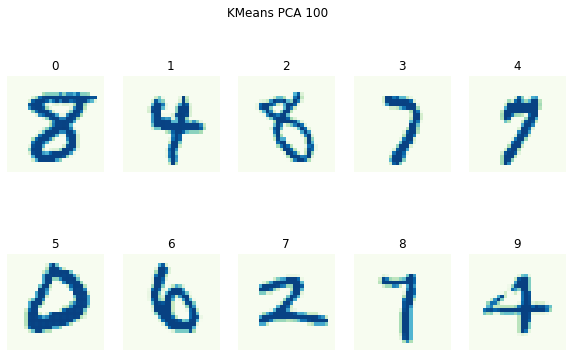

In [35]:
%%time
get_metrics(X=X_sample, y_true=y_sample, y_pred=kmeans_pca_100.labels_, model_name='KMeans PCA 100')
plot_centers(X_sample, list(set(kmeans_pca_100.labels_)), 'KMeans PCA 100')

Качество кластеризации и центры по сравнению с размерностью 10 почти не изменилось, поэтому оставим 10

Для сравнения попробуем tSNE

### tSNE

In [36]:
%%time
X_tsne = TSNE(n_components=2).fit_transform(X_sample)
X_tsne.shape

CPU times: user 3min 17s, sys: 4.89 s, total: 3min 22s
Wall time: 13.7 s


(5000, 2)

KMeans tSNE 2. Silhouette score: 0.0372, V-score: 0.7004


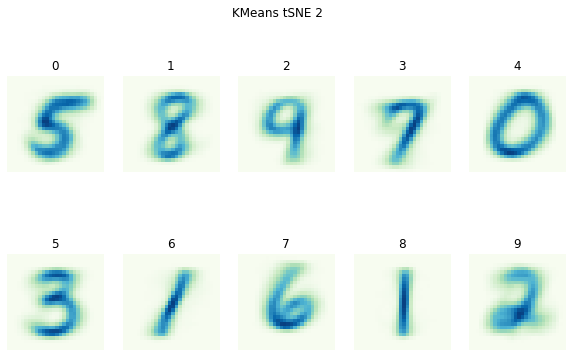

In [39]:
kmeans_tsne_2 = KMeans(n_clusters=10).fit(X_tsne)

get_metrics(X_sample, y_sample, kmeans_tsne_2.labels_, 'KMeans tSNE 2')
cluster_centers = get_clusters_centers(X_sample, kmeans_tsne_2.labels_)
plot_centers(cluster_centers, list(set(kmeans_tsne_2.labels_)), 'KMeans tSNE 2')

Картинка не такая четкая, как при PCA, однако качество кластеризации сильно улучшилось. Теперь все цифры кроме 4 хорошо различимы, однако 2 кластера походи на единицу. Попробуем увеличить параметры n_init и max_iter

KMeans tSNE 2. Silhouette score: 0.037, V-score: 0.6944


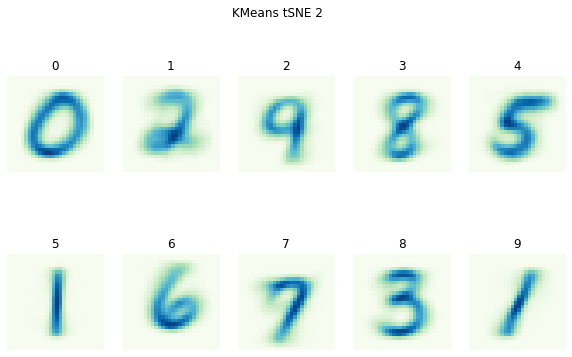

In [40]:
kmeans_tsne_2 = KMeans(n_clusters=10, n_init=30, max_iter=1000).fit(X_tsne)

get_metrics(X_sample, y_sample, kmeans_tsne_2.labels_, 'KMeans tSNE 2')
cluster_centers = get_clusters_centers(X_sample, kmeans_tsne_2.labels_)
plot_centers(cluster_centers, list(set(kmeans_tsne_2.labels_)), 'KMeans tSNE 2')

Тут тоже это не улучшило качество. Попробуем иерархическую кластеризацию

## AgglomerativeClustering

In [41]:
%%time
hierarchical_pca_10 = AgglomerativeClustering(n_clusters=10).fit(X_pca_10)

CPU times: user 623 ms, sys: 60.5 ms, total: 683 ms
Wall time: 718 ms


Hierarchical PCA 10. Silhouette score: 0.0362, V-score: 0.5231


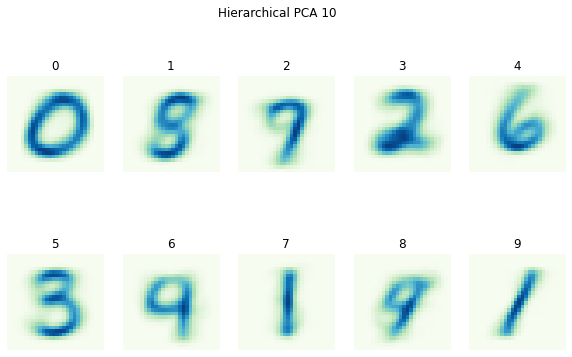

In [42]:
get_metrics(X_sample, y_sample, hierarchical_pca_10.labels_, 'Hierarchical PCA 10')
cluster_centers = get_clusters_centers(X_sample, hierarchical_pca_10.labels_)
plot_centers(cluster_centers, list(set(hierarchical_pca_10.labels_)), 'Hierarchical PCA 10')

Лучше, чем KMeans PCA 10, но хуже, чем KMeans с tSNE. Попробуем применить tSNE

In [43]:
%%time
hierarchical_tsne_2 = AgglomerativeClustering(n_clusters=10).fit(X_tsne)

CPU times: user 471 ms, sys: 39.1 ms, total: 510 ms
Wall time: 509 ms


Hierarchical tSNE 2. Silhouette score: 0.0498, V-score: 0.7448


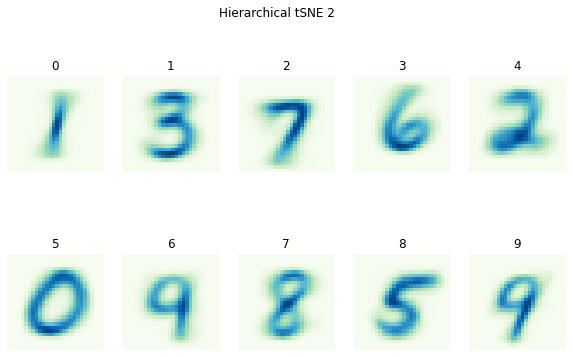

In [44]:
get_metrics(X_sample, y_sample, hierarchical_tsne_2.labels_, 'Hierarchical tSNE 2')
cluster_centers = get_clusters_centers(X_sample, hierarchical_tsne_2.labels_)
plot_centers(cluster_centers, list(set(hierarchical_tsne_2.labels_)), 'Hierarchical tSNE 2')

Результат стал лучше, однако 4 очень похожа на 9. Визуализируем это в 2-мерном пространстве

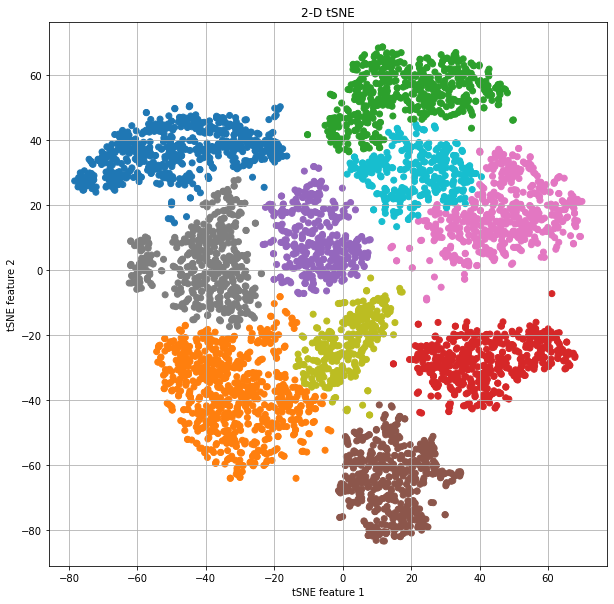

In [45]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(X_tsne[:,0], X_tsne[:,1], c=hierarchical_tsne_2.labels_, cmap=plt.cm.tab10)
ax.set_title('2-D tSNE')
ax.set_xlabel('tSNE feature 1')
ax.set_ylabel('tSNE feature 2')
ax.grid();

Попробуем SVD преобразование для иерархической кластеризации

In [46]:
X_svd_100 = TruncatedSVD(n_components=100).fit_transform(X_sample)
X_svd_100.shape

(5000, 100)

In [47]:
hierarchical_svd_100 = AgglomerativeClustering(n_clusters=10).fit(X_svd_100)

Hierarchical SVD 100. Silhouette score: 0.031, V-score: 0.6551


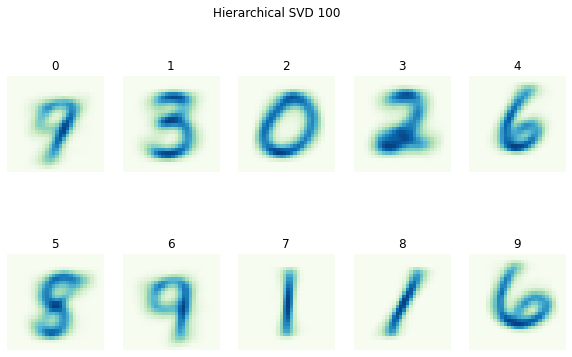

In [48]:
get_metrics(X_sample, y_sample, hierarchical_svd_100.labels_, 'Hierarchical SVD 100')
cluster_centers = get_clusters_centers(X_sample, hierarchical_svd_100.labels_)
plot_centers(cluster_centers, list(set(hierarchical_svd_100.labels_)), 'Hierarchical SVD 100')

Качество хуже, чем при tSNE

Итак, наилучшая модель на выборке - иерархическая кластеризация с применением tSNE. Построим модель на полных данных

In [50]:
%%time
X_tsne = TSNE(n_components=2, n_jobs=8).fit_transform(X)
X_tsne.shape

CPU times: user 1h 22min 17s, sys: 4min 34s, total: 1h 26min 52s
Wall time: 7min 41s


(70000, 2)

In [ ]:
%%time
hierarchical_tsne = AgglomerativeClustering(n_clusters=10).fit(X_tsne)

In [ ]:
get_metrics(X, y, hierarchical_tsne.labels_, 'Hierarchical tSNE')
cluster_centers = get_clusters_centers(X, hierarchical_tsne.labels_)
plot_centers(cluster_centers, list(set(hierarchical_tsne.labels_)), 'Hierarchical tSNE')